## Homework #7

Due Nov 11th


# Problem 1.  Kalman Filtering

Define a python class object to preform Kalman tracking of a moving object

using the following state equations:

Position
* pos_x(k+1) = pos_x(k) + vel_x(k)*dt +v
* pos_y(k+1) = pos_y(k) + vel_y(k)*dt +v

velocity
* vel_x(k+1) = vel_x(k) + acc_x(k)*dt +v
* vel_y(k+1) = vel_y(k) + acc_y(k)*dt +v

acceleration
* acc_x(k+1) = acc_x(k) + Ux(k) +v 
* acc_y(k+1) = acc_y(k) + Uy(k) +v

observation equations
* meas_x(k+1) = pos_x(k+1)+e
* meas_y(k+1) = pos_y(k+1)+e

note, velocity and acceleration are not observed

Let e and v be random normal variables

## A  
Write code to simulate the forward model.  E.g. given an initial starting position,velocity, and acceleration, and the input vector U, simulate the measurement of the position (Y)

## B
Write the code for the kalman tracker.  E.g. given the measurement vector (Y; from part 1), estimate the underlying true position, velocity, and acceleration.



In [ ]:
import numpy as np

class KalmanSimulator:
    def __init__(self, dt, initial_pos, initial_vel, initial_acc, process_noise_var, measurement_noise_var):
        self.dt = dt
        self.pos = np.array(initial_pos, dtype=float)   
        self.vel = np.array(initial_vel, dtype=float)   
        self.acc = np.array(initial_acc, dtype=float)   
        
        self.process_noise_var = process_noise_var      
        self.measurement_noise_var = measurement_noise_var  

    def simulate(self, U, steps):
        true_positions = []
        measurements = []
        
        for _ in range(steps):
   
            process_noise = np.random.normal(0, self.process_noise_var, 2)
            self.pos += self.vel * self.dt + process_noise
            self.vel += self.acc * self.dt + process_noise
            self.acc += U + process_noise


            true_positions.append(self.pos.copy())
            
       
            measurement_noise = np.random.normal(0, self.measurement_noise_var, 2)
            meas_pos = self.pos + measurement_noise
            measurements.append(meas_pos)

        return np.array(true_positions), np.array(measurements)
    

dt = 0.1
initial_pos = [0, 0]
initial_vel = [1, 1]
initial_acc = [0.1, 0.1]
process_noise_var = 1e-2
measurement_noise_var = 1e-1
U = np.array([0.05, 0.05])  # Input acceleration
steps = 50

# Create a simulator object and generate data
simulator = KalmanSimulator(dt, initial_pos, initial_vel, initial_acc, process_noise_var, measurement_noise_var)
true_positions, measurements = simulator.simulate(U, steps)

# Output simulated measurements (Y)
print("Generated Measurements (Y):\n", measurements[:5])




# PART B--------------------------------------------------------
class KalmanTracker:
    def __init__(self, dt, process_noise_var, measurement_noise_var):
        self.dt = dt
        
        # State vector [pos_x, pos_y, vel_x, vel_y, acc_x, acc_y]
        self.state = np.zeros(6)
        
        # State covariance matrix
        self.P = np.eye(6) * 1e3
        
        # Process noise and measurement noise
        self.Q = np.eye(6) * process_noise_var
        self.R = np.eye(2) * measurement_noise_var

        # State transition matrix F
        self.F = np.array([
            [1, 0, dt, 0, 0.5 * dt**2, 0],
            [0, 1, 0, dt, 0, 0.5 * dt**2],
            [0, 0, 1, 0, dt, 0],
            [0, 0, 0, 1, 0, dt],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])

        # Observation matrix H (observing only position)
        self.H = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0]
        ])

    def predict(self):
        # Predict state
        self.state = self.F @ self.state
        # Update covariance matrix
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.state[:2]  # Return predicted position information

    def update(self, measurement):
        # Calculate Kalman gain
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)

        # Update state vector and covariance
        y = measurement - (self.H @ self.state)  # Calculate observation residual
        self.state += K @ y
        self.P = (np.eye(6) - K @ self.H) @ self.P
        return self.state  # Return estimated state (position, velocity, acceleration)

# Initialize Kalman Tracker
tracker = KalmanTracker(dt, process_noise_var, measurement_noise_var)

# Perform tracking using Kalman filter
estimated_states = []
for measurement in measurements:
    tracker.predict()
    estimated_state = tracker.update(measurement)
    estimated_states.append(estimated_state)

# Output estimated states
estimated_states = np.array(estimated_states)
print("PART B------------------------------------------------")
print("Estimated States (Position, Velocity, Acceleration):\n", estimated_states[:5])



Generated Measurements (Y):
 [[0.23291549 0.13003479]
 [0.2396304  0.10827593]
 [0.4932751  0.4467054 ]
 [0.46380317 0.36215378]
 [0.43303151 0.34108817]]
PART B------------------------------------------------
Estimated States (Position, Velocity, Acceleration):
 [[ 2.32892435e-01  1.30021919e-01  2.31731471e-02  1.29373763e-02
   1.15289289e-03  6.43650562e-04]
 [ 2.39587685e-01  1.08498857e-01  6.68553914e-02 -2.14390685e-01
   7.53850240e-03 -3.26852621e-02]
 [ 4.58857701e-01  3.96561729e-01  1.65178465e+00  2.09037034e+00
   3.52946032e+00  5.09850136e+00]
 [ 4.94288641e-01  4.08244813e-01  8.27460245e-01  8.20303546e-01
  -7.39872844e-01 -1.35630984e+00]
 [ 4.57545319e-01  3.65969176e-01 -1.36548293e-01 -2.18680635e-01
  -3.76826316e+00 -4.43006349e+00]]


# Problem 2.

## A.
Open CV has both the CAMShift and MeanShift functions for tracking, however, I want you to code your own simple version of the MeanShift function from scratch.  Given a video (you can use your webcam), define a ROI circle.  For each frame of the video, compute the center-of-mass of a gray-scale image in a circle around the previous center-of-mass.  Track the center of mass across frames

## B.
Implement a demo using the openCV versions (cv2.MeanShift and cv2.CAMshift)




In [ ]:
import cv2
import numpy as np

def initialize_mean_shift(video_capture, initial_center, roi_radius):

    ret, frame = video_capture.read()
    x, y = initial_center
    roi = frame[y - roi_radius:y + roi_radius, x - roi_radius:x + roi_radius]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)


    mask = cv2.inRange(hsv_roi, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
    roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
    cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
    
    return roi_hist, initial_center, roi_radius

def mean_shift_tracking(video_capture, roi_hist, initial_center, roi_radius):
    center = np.array(initial_center, dtype=np.float32)
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break


        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

        x, y = int(center[0]), int(center[1])
        roi_dst = dst[y - roi_radius:y + roi_radius, x - roi_radius:x + roi_radius]
        
        moments = cv2.moments(roi_dst)
        if moments['m00'] != 0:
            center[0] = x + (moments['m10'] / moments['m00']) - roi_radius
            center[1] = y + (moments['m01'] / moments['m00']) - roi_radius


        cv2.circle(frame, (int(center[0]), int(center[1])), roi_radius, (0, 255, 0), 2)
        cv2.imshow("Improved MeanShift Tracking", frame)


        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    video_capture.release()
    cv2.destroyAllWindows()

video_capture = cv2.VideoCapture(0)
initial_center = (320, 240)  
roi_radius = 50              
roi_hist, initial_center, roi_radius = initialize_mean_shift(video_capture, initial_center, roi_radius)
mean_shift_tracking(video_capture, roi_hist, initial_center, roi_radius)


In [ ]:
import cv2
import numpy as np

video_capture = cv2.VideoCapture(0)
_, frame = video_capture.read()

x, y, w, h = 200, 200, 100, 100 
roi = frame[y:y+h, x:x+w]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

track_window = (x, y, w, h)

term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

    # MeanShift
    ret, track_window = cv2.meanShift(dst, track_window, term_crit)
    x, y, w, h = track_window
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imshow("MeanShift", frame)

    # CAMShift
    ret, track_window = cv2.CamShift(dst, track_window, term_crit)
    pts = cv2.boxPoints(ret)
    pts = np.int0(pts)
    frame = cv2.polylines(frame, [pts], True, (0, 0, 255), 2)
    cv2.imshow("CAMShift", frame)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()


# Problem 3. 
Implement a Haar cascade detector for finding faces in a video feed. Include two detectors for the frontal and profile views of a face.

Pretrained haar models can be found at:
https://github.com/opencv/opencv/tree/master/data/haarcascades

In [ ]:
import cv2
import numpy as np

frontal_face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
profile_face_cascade = cv2.CascadeClassifier('haarcascade_profileface.xml')

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frontal_faces = frontal_face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    profile_faces = profile_face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    gray_flipped = cv2.flip(gray, 1)
    profile_faces_flipped = profile_face_cascade.detectMultiScale(
        gray_flipped,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    for (x, y, w, h) in frontal_faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    for (x, y, w, h) in profile_faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    for (x, y, w, h) in profile_faces_flipped:
        x_flipped = frame.shape[1] - x - w  
        cv2.rectangle(frame, (x_flipped, y), (x_flipped + w, y + h), (255, 0, 0), 2)

    cv2.imshow('Face Detection', frame)

    # 'q' quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# Problem 4 [ECE 2690 students]
Using the openCV tools for annotating images and training Haar models as shown in class, build a simple Haar classifier model to recognize the Catherdral of Learning.  

Instructions can be found at:
https://github.com/bilardi/how-to-train-cascade

* Download from the internet or take about 30 pictures of Cathy as your positives (this is not really enough for a proper model, but it should be ok to demo the concept)

* Download from the internet or take about 15 pictures for your negatives.  Landscapes (obviously without Cathy in the picture) would work best






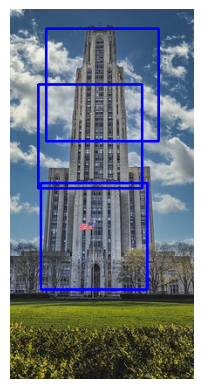

In [29]:
import cv2
import matplotlib.pyplot as plt

cathedral_cascade = cv2.CascadeClassifier('classifier/cascade.xml')

image_path = '1/1.png'  
frame = cv2.imread(image_path)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

cathedrals = cathedral_cascade.detectMultiScale(
    gray, 
    scaleFactor=1.1, 
    minNeighbors=10, 
    minSize=(100, 100)   
)

for (x, y, w, h) in cathedrals:
    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)
plt.axis('off') 
plt.show()

